In [1]:
from config import DATASET_PATH
images_folder_path = DATASET_PATH / "Potato___Late_blight"

C:\Users\dn200\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1\PlantVillage\Potato___Late_blight\7ec28081-7b26-4519-a406-48ff4edb69ea___RS_LB 2622.JPG


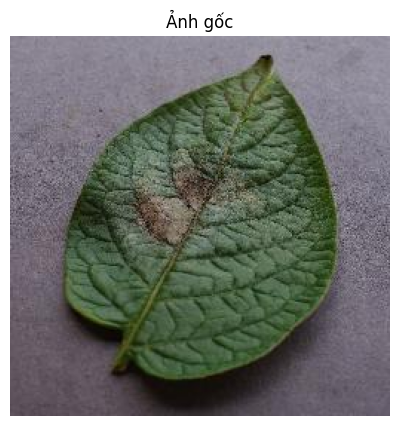

In [2]:
import cv2
import utils
image_path = utils.get_random_file(images_folder_path)
print(image_path)
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
utils.show_images([img_rgb], ["Ảnh gốc"])

# SEGMENTATION
---

### SEG.1. Phân đoạn lá dùng Otsu trên kênh sáng (V/L*)

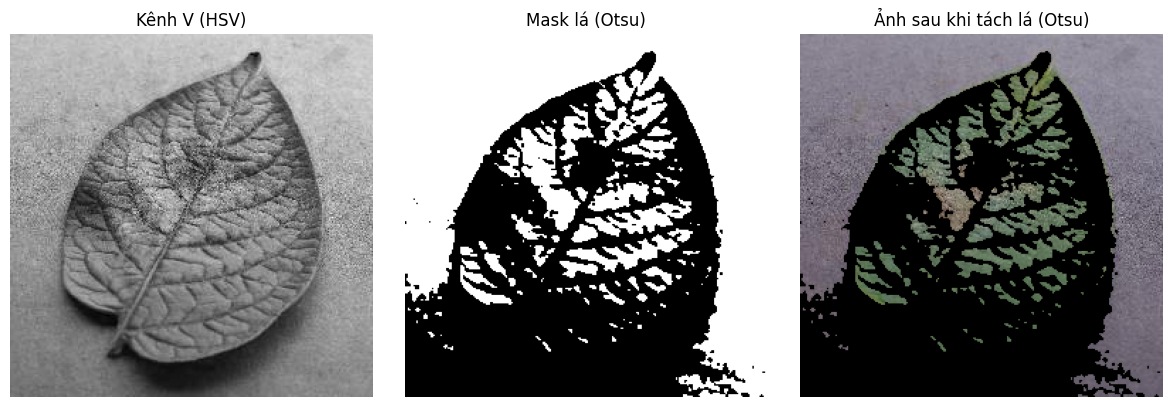

In [3]:
# Chuyển sang HSV
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
v = img_hsv[:, :, 2]  # kênh Value

# Làm mờ Gaussian để giảm nhiễu
v_blur = cv2.GaussianBlur(v, (5, 5), 0)

# Otsu threshold
_, mask_leaf_otsu = cv2.threshold(
    v_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Với một số ảnh, nền có thể trắng hơn lá → cần đảo lại mask
# Ta kiểm tra trung bình cường độ V trong vùng trắng/đen để quyết định
mean_foreground = v_blur[mask_leaf_otsu == 255].mean()
mean_background = v_blur[mask_leaf_otsu == 0].mean()

if mean_foreground < mean_background:
    mask_leaf_otsu = cv2.bitwise_not(mask_leaf_otsu)

# Áp mask lên ảnh RGB
leaf_otsu = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_leaf_otsu)

utils.show_images(
    [v, mask_leaf_otsu, leaf_otsu],
    ["Kênh V (HSV)", "Mask lá (Otsu)", "Ảnh sau khi tách lá (Otsu)"],
    cols=3,
    figsize=(12, 4)
)


### SEG.1.2. Phân đoạn lá dựa trên màu trong không gian HSV

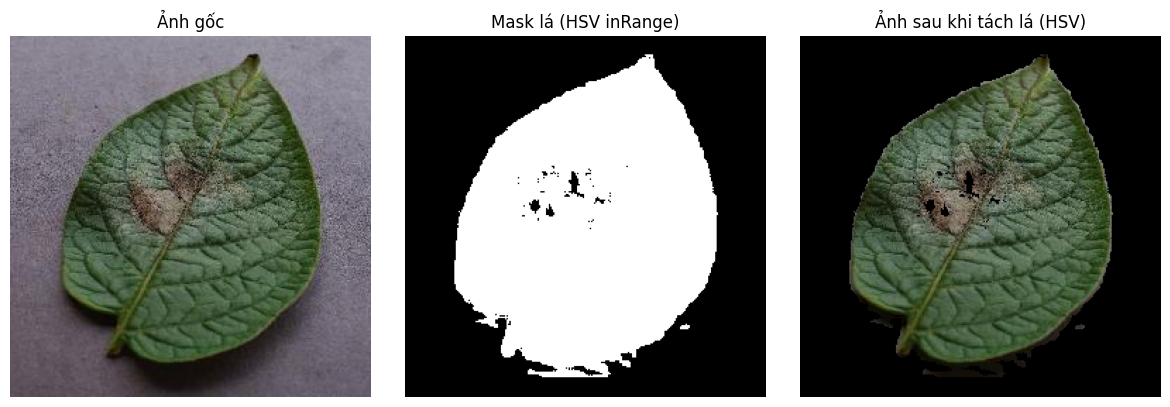

In [4]:
import numpy as np
# Giả sử lá chủ yếu là màu xanh lá cây
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Ngưỡng "xanh lá" phổ biến (có thể chỉnh tay cho phù hợp từng bộ dữ liệu)
lower_green = np.array([12, 25, 10])   # H, S, V
upper_green = np.array([100, 255, 255])

mask_leaf_hsv = cv2.inRange(img_hsv, lower_green, upper_green)

leaf_hsv = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_leaf_hsv)

utils.show_images(
    [img_rgb, mask_leaf_hsv, leaf_hsv],
    ["Ảnh gốc", "Mask lá (HSV inRange)", "Ảnh sau khi tách lá (HSV)"],
    cols=3,
    figsize=(12, 4)
)


###  Làm sạch mask bằng phép toán hình thái học

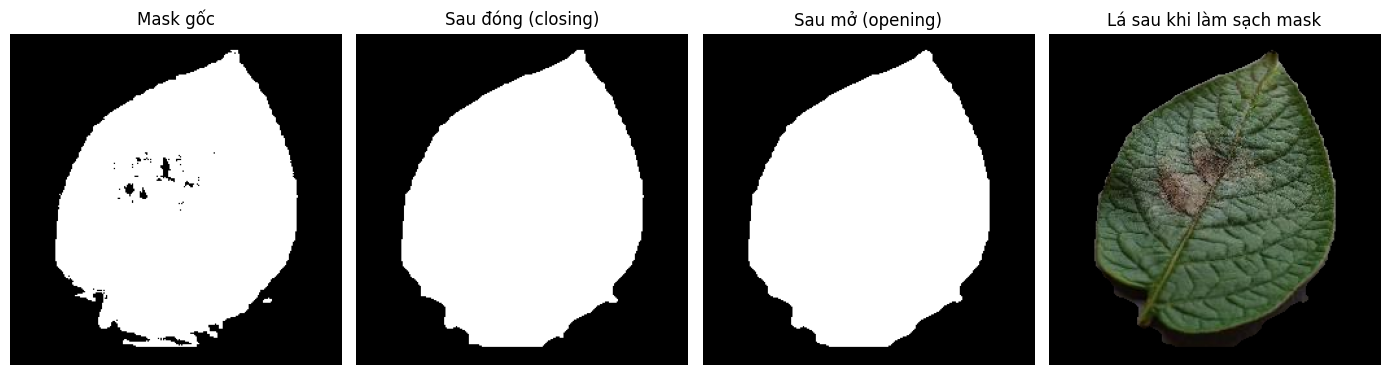

In [5]:
# Chọn 1 mask lá để làm ví dụ (ở đây dùng mask_leaf_hsv)
mask_leaf = mask_leaf_hsv.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# Đóng: lấp lỗ nhỏ trong vùng lá
mask_closed = cv2.morphologyEx(mask_leaf, cv2.MORPH_CLOSE, kernel, iterations=3)
# Mở: loại bỏ các đốm nhỏ ở nền
mask_clean = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel, iterations=1)

leaf_clean = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_clean)

utils.show_images(
    [mask_leaf, mask_closed, mask_clean, leaf_clean],
    ["Mask gốc", "Sau đóng (closing)", "Sau mở (opening)", "Lá sau khi làm sạch mask"],
    cols=4,
    figsize=(14, 4)
)

# S.2. Phân đoạn vùng bệnh trên lá

### Phân đoạn vùng bệnh bằng ngưỡng trên kênh a*/b*

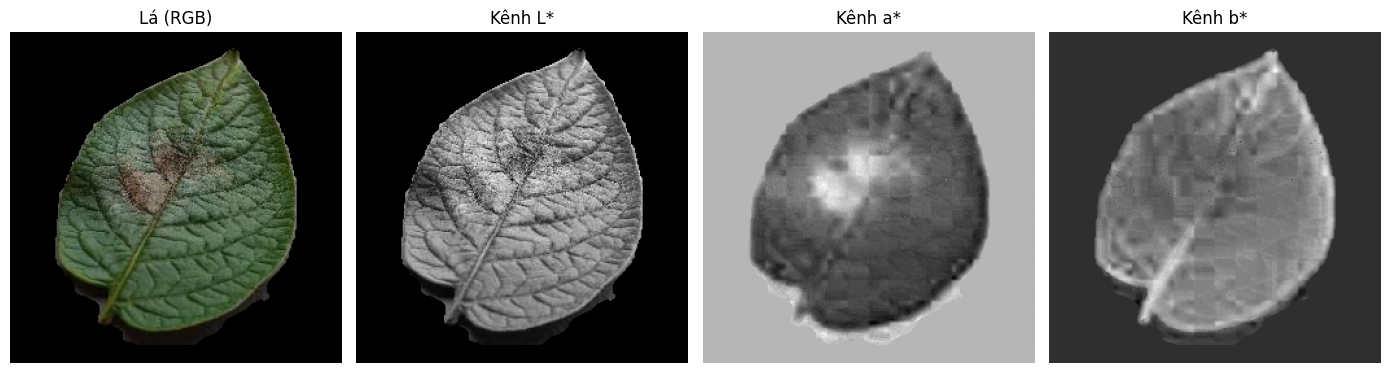

In [6]:
# Dùng mask_clean từ bước trước
mask_leaf = mask_clean

# Cắt vùng lá từ ảnh RGB
leaf_only = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_leaf)

# Chuyển RGB -> Lab (phù hợp phân biệt sắc xanh/đỏ/vàng)
leaf_lab = cv2.cvtColor(leaf_only, cv2.COLOR_RGB2LAB)

L, a, b = cv2.split(leaf_lab)

utils.show_images(
    [leaf_only, L, a, b],
    ["Lá (RGB)", "Kênh L*", "Kênh a*", "Kênh b*"],
    cols=4,
    figsize=(14, 4)
)


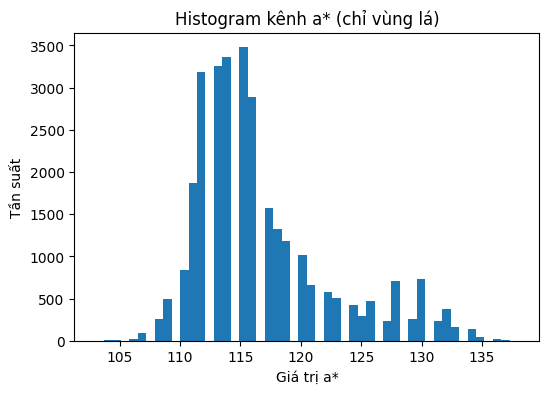

In [7]:
import matplotlib.pyplot as plt
# Chỉ xét các pixel thuộc lá
a_leaf = a.copy()
a_leaf[mask_leaf == 0] = 0  # nền = 0 để khỏi ảnh hưởng histogram

plt.figure(figsize=(6, 4))
plt.hist(a_leaf[mask_leaf == 255].flatten(), bins=50)
plt.title("Histogram kênh a* (chỉ vùng lá)")
plt.xlabel("Giá trị a*")
plt.ylabel("Tần suất")
plt.show()


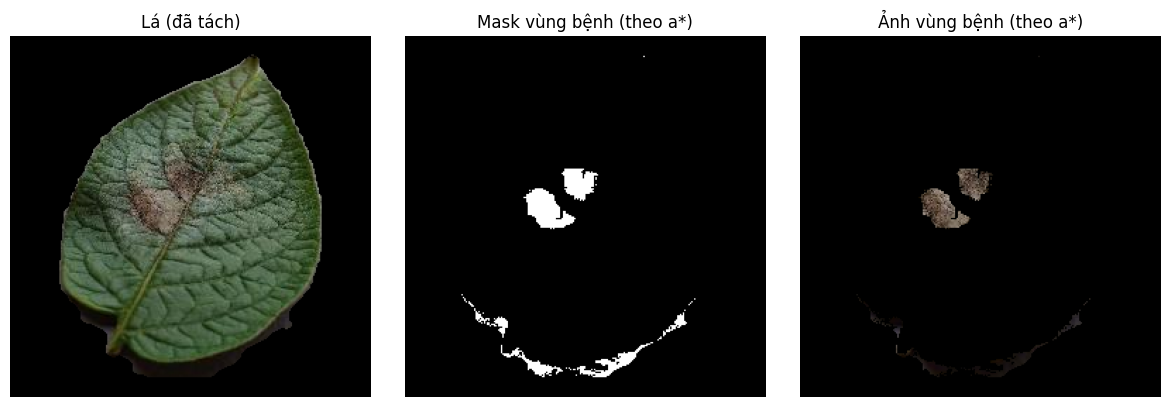

In [8]:
# Ví dụ: chọn ngưỡng trên a* (cần tự điều chỉnh theo histogram thực tế)
thresh_a = 130  # TODO: chỉnh tay sau khi xem histogram
mask_lesion_a = np.zeros_like(mask_leaf)
mask_lesion_a[(a >= thresh_a) & (mask_leaf == 255)] = 255

lesion_a = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lesion_a)

utils.show_images(
    [leaf_only, mask_lesion_a, lesion_a],
    ["Lá (đã tách)", "Mask vùng bệnh (theo a*)", "Ảnh vùng bệnh (theo a*)"],
    cols=3,
    figsize=(12, 4)
)


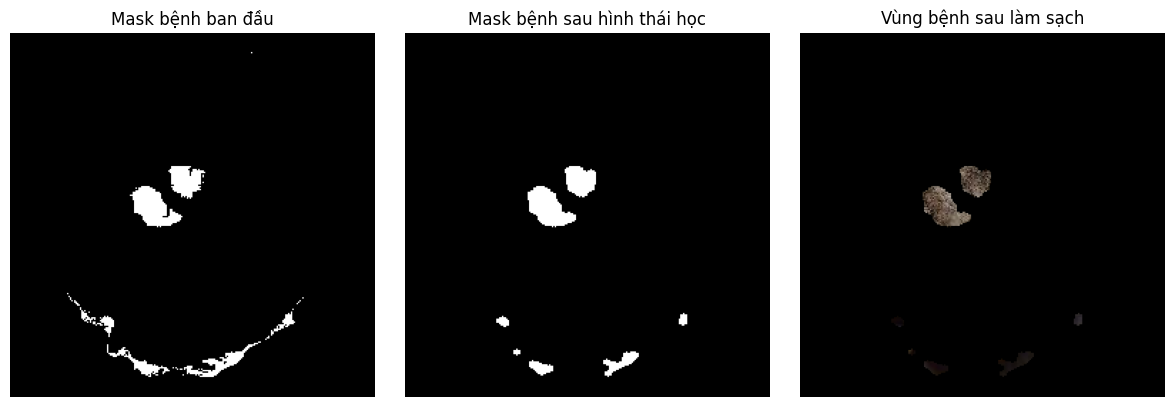

In [9]:
mask_lesion = mask_lesion_a.copy()  # hoặc mask_lesion_a nếu bạn dùng ngưỡng a*

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Xóa nhiễu nhỏ và làm mượt biên
mask_lesion_clean = cv2.morphologyEx(mask_lesion, cv2.MORPH_OPEN, kernel, iterations=1)
mask_lesion_clean = cv2.morphologyEx(mask_lesion_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

lesion_clean = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lesion_clean)

utils.show_images(
    [mask_lesion, mask_lesion_clean, lesion_clean],
    ["Mask bệnh ban đầu", "Mask bệnh sau hình thái học", "Vùng bệnh sau làm sạch"],
    cols=3,
    figsize=(12, 4)
)


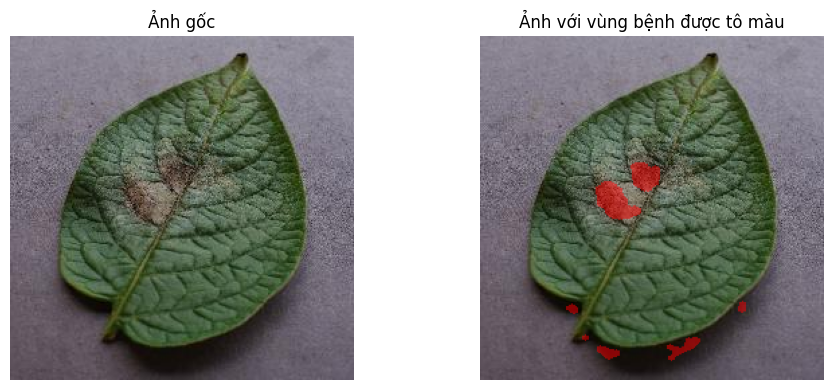

In [10]:
# Copy ảnh gốc
overlay = img_rgb.copy()

# Tạo lớp màu đỏ trên vùng bệnh
red_layer = np.zeros_like(img_rgb)
red_layer[:, :, 0] = 255  # kênh R = 255

alpha = 0.5  # độ trong suốt

# Vùng cần tô màu: mask_lesion_area
mask_bool = lesion_clean.astype(bool)

# Trộn màu: overlay[mask] = alpha*overlay + (1-alpha)*red_layer
overlay[mask_bool] = (
    alpha * overlay[mask_bool] + (1 - alpha) * red_layer[mask_bool]
).astype(np.uint8)

utils.show_images(
    [img_rgb, overlay],
    ["Ảnh gốc", "Ảnh với vùng bệnh được tô màu"],
    cols=2,
    figsize=(10, 4)
)
